In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import matplotlib

# ignore warnings
warnings.simplefilter("ignore")

In [2]:
# threshold for the f-I curves
threshold = 3.0

# threshold for ap
ap_amp_thresh_neg = -1.0
ap_amp_thresh_pos = 1.0

# Experimental data preparation

In [3]:
# read the efeatures and retained only the neurons selected during the preliminary quality checks
experiment_df = pd.read_csv('preprocessed_data_efeatures_selection.csv')

In [4]:
# reduce the attributes to the AP counts
experiment_df = experiment_df[['state',  'step current', 'stim dur', 'protocol', 
                               'AP_count', 'AP_count_before_stim', 'AP_count_after_stim']]

In [5]:
# rename columns
experiment_df.rename(columns={'stim dur':'duration', 'step current':'amplitude'}, inplace=True)

In [6]:
# rename state from control to normal
experiment_df['state'].replace({'control':'normal'}, inplace=True)

In [7]:
# we are not interested 
# boundaries
experiment_df = pd.concat([
    experiment_df[(experiment_df['protocol'] == 'fi') & experiment_df['amplitude'].between(20, 300)],
    experiment_df[(experiment_df['protocol'] == 'rmih') & experiment_df['amplitude'].between(-200, -50)],
    experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == 2000) & experiment_df['amplitude'].between(-200, -50)]
])

<AxesSubplot:title={'center':'f-I curve'}, xlabel='amplitude', ylabel='AP_count'>

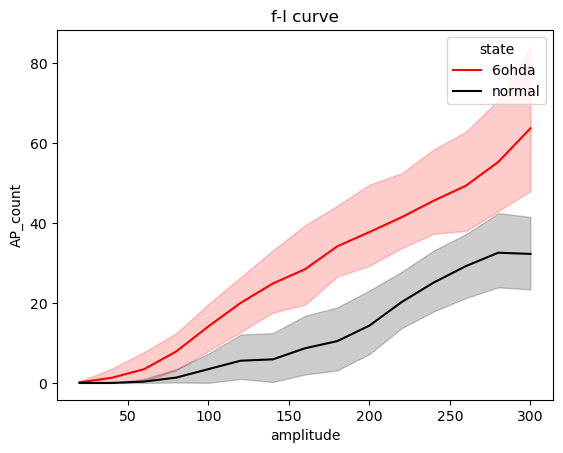

In [8]:
plt.title('f-I curve')
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['red', 'black'])

<AxesSubplot:title={'center':'Rebound spikes without bias'}, xlabel='amplitude', ylabel='AP_count_after_stim'>

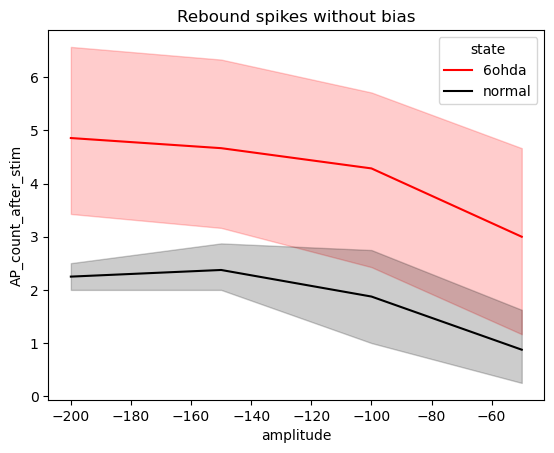

In [9]:
plt.title('Rebound spikes without bias')
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'rmih'], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])

<AxesSubplot:title={'center':'Rebound spikes with bias'}, xlabel='amplitude', ylabel='AP_count_after_stim'>

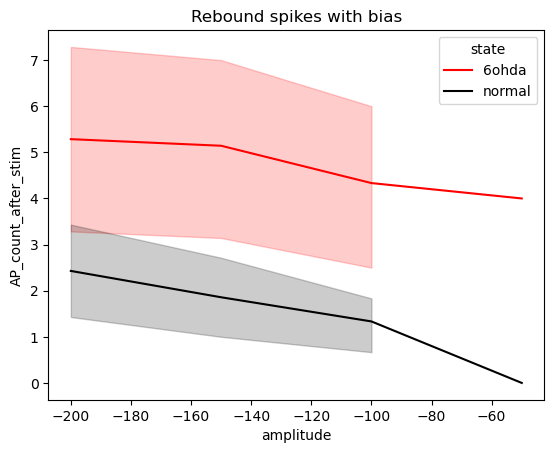

In [10]:
plt.title('Rebound spikes with bias')
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'tburst'], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])

# Simulation data preparation

In [11]:
# read files
df = pd.read_csv('qc.csv') 
df_no_km = pd.read_csv('qc_no_km.csv') 

In [12]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     4900
normal     686
Name: state, dtype: int64

In [13]:
# check dataframe shape
df.shape, df_no_km.shape

((206682, 14), (206682, 14))

## Filter out configurations with short AP or too deep AHP

In [14]:
# load configurations
hof = np.load('hof_chk0.npy', allow_pickle=True).tolist()

print('# hof (before)', len(hof))

for k in list(hof.keys()):
    
    for ke, ve in hof[k]['error'].copy().items():
        # pick up errors related to AP ampl
        if ke.split('.')[-1] in [ 'AP_amplitude', 'AP1_amp_rev', 'AP2_amp_rev' ]:
            
            # check error
            if ve < 0 and ve < ap_amp_thresh_neg or ve > 0 and ve > ap_amp_thresh_pos:
                del hof[k]
                break

print('# hof (after)', len(hof))

# keys to keep
keep = list(hof.keys())

# clear
del hof

# hof (before) 5586
# hof (after) 1257


In [15]:
df.set_index(['etype', 'cellid', 'seed'], inplace=True)
df_no_km.set_index(['etype', 'cellid', 'seed'], inplace=True)

# filter out configurations with short AP
df = df.loc[keep, :]
df_no_km = df_no_km.loc[keep, :]

df.reset_index(inplace=True)
df_no_km.reset_index(inplace=True)

In [16]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     1149
normal     108
Name: state, dtype: int64

# Comparing curves for hyperpolarizing and depolarizing current steps

In [17]:
y_variable = {'fi':'AP_count', 'tburst':'AP_count_after_stim', 'rmih':'AP_count_after_stim' }

for _protocol, _y_variable in y_variable.items():
    for _state in experiment_df.state.unique():

        # get the experimental curves
        exp_curve = experiment_df[(experiment_df['state']==_state)&(experiment_df['protocol']==_protocol)]
        exp_curve = exp_curve.groupby(['amplitude', 'duration'])[_y_variable].describe()[['count', 'mean', 'std']]
        exp_curve.dropna(inplace=True)

        # go over the simulated curves
        for k, g in df[(df['state']==_state)&(df['protocol']==_protocol)].groupby(['cellid', 'seed']):
            sim_curve = g.groupby(['amplitude', 'duration'])[_y_variable].describe()[['mean']]
            sim_curve.dropna(inplace=True)

            # only cases shown in the experiments
            sim_curve = sim_curve.loc[exp_curve.index, :]

            # max abs z-score
            max_err = ((sim_curve['mean'] - exp_curve['mean']) / (exp_curve['std'] + 0.001)).abs().max()

            if max_err > threshold:
                # remove if exceeding the threshold
                k += (_state, )
                df.drop(df[(df[['cellid', 'seed', 'state']]==k).all(axis=1)].index, inplace=True)

In [18]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     1100
normal      83
Name: state, dtype: int64

# Comparing curves for depolarizing current steps with and without $K_M$

## Remove individuals that fires spontaneously after $K_M$ blockade

In [19]:
df.set_index(['etype', 'cellid', 'seed'], inplace=True)
df_no_km.set_index(['etype', 'cellid', 'seed'], inplace=True)

# remove neurons that fires spontaneously after KM blockade
df_no_km.drop(df_no_km[df_no_km['AP_count_before_stim'] > 0].index.drop_duplicates(), inplace=True)

# FILTER
index = set(df.index).intersection(df_no_km.index)
df = df.loc[index, :]
df_no_km = df_no_km.loc[index, :]

# reset keys
df.reset_index(inplace=True)
df_no_km.reset_index(inplace=True)

In [20]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     922
normal     78
Name: state, dtype: int64

## Baseline voltage

In [21]:
df.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -67.201510  1.519679
       rmih     -73.676595  2.178094
       tburst   -67.203986  1.519669
normal fi       -68.376870  0.966597
       rmih     -76.154124  2.018472
       tburst   -68.379350  0.966562

In [22]:
df_no_km.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -65.433803  2.040662
       rmih     -72.955591  2.366354
       tburst   -65.436281  2.040651
normal fi       -65.309483  1.597698
       rmih     -74.893766  2.227398
       tburst   -65.311966  1.597595

## Compare f-I curves between control and after $K_M$ blockade

In [23]:
# calculate the f-I curves for experiments
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])
sim_curve_no_km = df_no_km[df_no_km['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])

In [24]:
# p values threshold
alpha = 0.1

for k in sim_curve.index.drop_duplicates():
    # select curve for one neuron
    _sim_curve = sim_curve.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    _sim_curve_no_km = sim_curve_no_km.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    
    # tendency of firing (whether increase or decrease after M blockade)
    tendency = (_sim_curve.set_index('amplitude')['AP_count'] - _sim_curve_no_km.set_index('amplitude')['AP_count']).mean()
    
    if tendency > 0:
        df.drop(df[(df[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
        df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
    else:
        # compare normal vs xe991 curves
        p = stats.ranksums(_sim_curve.to_numpy()[:, 1], _sim_curve_no_km.to_numpy()[:, 1] )[1]        

        # rheobase
        rheo_3 = _sim_curve.loc[_sim_curve[_sim_curve['AP_count'] >= 3].index[0], 'amplitude']
        rheo_no_km_3 = _sim_curve_no_km.loc[_sim_curve_no_km[_sim_curve_no_km['AP_count'] >= 3].index[0], 'amplitude']

        if (k[2] == '6ohda' and (p < (1-alpha) or abs(rheo_3-rheo_no_km_3) > 0)) or \
        (k[2] == 'normal' and (p >= alpha or abs(rheo_3-rheo_no_km_3) > 80)):
            df.drop(df[(df[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
            df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)

In [25]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    39
6ohda     21
Name: state, dtype: int64

# Compare simulated and experimental curves after selection

In [26]:
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()
exp_curve = experiment_df[experiment_df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()

In [27]:
stats.ranksums(sim_curve[sim_curve.state == '6ohda'].to_numpy()[:, 2], exp_curve[exp_curve.state == '6ohda'].to_numpy()[:, 2] )[1]  

0.49373011668276234

In [28]:
stats.ranksums(sim_curve[sim_curve.state == 'normal'].to_numpy()[:, 2], exp_curve[exp_curve.state == 'normal'].to_numpy()[:, 2] )[1]  

0.7557356175737271

<AxesSubplot:xlabel='amplitude', ylabel='AP_count'>

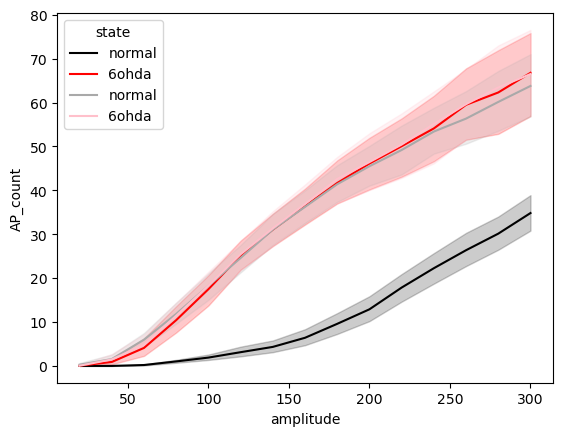

In [29]:
ax = sns.lineplot(data=df[df['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['black', 'red'], hue_order=['normal', '6ohda'])
sns.lineplot(data=df_no_km[df_no_km['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['darkgray', 'pink'], hue_order=['normal', '6ohda'], ax=ax)

# Save models to files

In [30]:
len(np.load('hof_chk0.npy', allow_pickle=True).tolist())

5586

In [31]:
def filter_models(filename, id_list, fileout=None):
    good_models = {}
    for k, v in np.load(filename, allow_pickle=True).tolist().items():
       if k in id_list: 
         good_models.update({k:v})
        
    if fileout:
        np.save(fileout, good_models, allow_pickle=True)

In [32]:
filter_models("hof_chk0.npy", \
              df[['etype', 'cellid', 'seed']].drop_duplicates().set_index(['etype', 'cellid', 'seed']).index.tolist(), \
              fileout="hof_chk1.npy")